## Introduction

By: Vishnu Rangiah 

This project aims to clearly display the metrics collected in crime reports in LA. The data is collected by the city of LA and can be found here [link]. We will begin by cleaning and preforming a simple EDA on the data then focus on the interactive dashbord which will be created using Tableau.

### Project Objectives

***Visualizations***
- Display LA neighborhoods with the most crime.
- What crimes are most popular per area?
- Display a heat map per area that shows popularity of each crime 
    - Another based on time per hour of day
    - Another per week, per month

Sources:
- https://www.kaggle.com/ambarish/eda-lacrimes-maps-timeseriesforecasts-xgboost/report
- https://www.kaggle.com/fedecape/it-s-crime-time-a-datetime-exploration


PowerBI crime dashboards for inspo:
- https://app.powerbigov.us/view?r=eyJrIjoiOGNhMjVhYTctMjk3Ny00MTZjLTliNDAtY2M2ZTQ5YWI3N2ViIiwidCI6IjJiOWY1N2ViLTc4ZDEtNDZmYi1iZTgzLWEyYWZkZDdjNjA0MyJ9
- https://compstat.nypdonline.org/2e5c3f4b-85c1-4635-83c6-22b27fe7c75c/view/89

***ML Models***
- Apply clustering models
- Time Series Analysis
    - XGBoost and ARIMA for predictions
- Trend Analysis split by neighborhood and time zone

***Productionzeing Pipeline***
- use pyspark & airflow for batch processing data
- use tableau to visualize results 

### Import Dataset

The LA Crime dataset can be found in the following sources:
- https://dev.socrata.com/foundry/data.lacity.org/2nrs-mtv8
- https://www.kaggle.com/cityofLA/crime-in-los-angeles
- https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8

"This dataset reflects incidents of crime in the City of Los Angeles dating back to 2020. This data is transcribed from original crime reports that are typed on paper and therefore there may be some inaccuracies within the data. Some location fields with missing data are noted as (0°, 0°). Address fields are only provided to the nearest hundred block in order to maintain privacy. This data is as accurate as the data in the database. Please note questions or concerns in the comments."

In [4]:
from sodapy import Socrata #importing dataset
import yaml #to sort API keys

import pandas as pd 
import datetime
from dateutil.relativedelta import relativedelta

import seaborn as sns #data visualizations

I use chose to use a configuration file to hide my apptoken, username, and password which are needed inorder to connect to the Socrata API. The steps to create an apptoken can be found here https://dev.socrata.com/foundry/data.lacity.org/2nrs-mtv8

In [5]:
with open("config.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

In [6]:
client = Socrata("data.lacity.org",
                 cfg['apptoken'],
                 username=cfg['username'],
                 password=cfg['password'])

We want to narrow our analysis to the last three months of reported crimes

In [7]:
three_month = datetime.datetime.now() + relativedelta(months=-3)
date_str = f"'{three_month.isoformat()}'"
date_str

"'2021-11-11T17:57:18.608465'"

In [8]:
results = client.get("2nrs-mtv8", where="date_rptd > " + date_str, limit = 100000)
results_df = pd.DataFrame.from_records(results) #pandas dataframe
results_df.head()

,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1_2,crm_cd,crm_cd_desc,...,weapon_desc,status,status_desc,crm_cd_1,crm_cd_2,location,lat,lon,cross_street,crm_cd_3
0,210319064,2021-11-12T00:00:00.000,2020-01-01T00:00:00.000,1200,03,Southwest,0398,1,121,"RAPE, FORCIBLE",...,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,121,812,600 W 41ST PL,34.0078,-118.2856,NaN,NaN
1,211115266,2021-11-12T00:00:00.000,2020-10-01T00:00:00.000,1000,11,Northeast,1132,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,NaN,IC,Invest Cont,740,NaN,3200 COLONY CIR,34.1121,-118.2776,NaN,NaN
2,210618965,2021-11-12T00:00:00.000,2020-04-14T00:00:00.000,0945,06,Hollywood,0639,2,946,OTHER MISCELLANEOUS CRIME,...,NaN,IC,Invest Cont,946,NaN,5300 RUSSELL AV,34.1042,-118.3072,NaN,NaN
3,211014473,2021-11-12T00:00:00.000,2020-07-29T00:00:00.000,1200,10,West Valley,1008,2,354,THEFT OF IDENTITY,...,NaN,IC,Invest Cont,354,NaN,7200 VALJEAN AV,34.2077,-118.4912,NaN,NaN
4,210618957,2021-11-12T00:00:00.000,2020-06-13T00:00:00.000,0001,06,Hollywood,0615,1,310,BURGLARY,...,NaN,IC,Invest Cont,310,NaN,2300 N CAHUENGA BL,34.1113,-118.3332,NaN,NaN


In [9]:
df = results_df

In [35]:
df.to_csv("crime_3month.csv")

In [24]:
# Code to get all of the data as a python generator from 2020 -> Present
# results_all = client.get_all("2nrs-mtv8", where="date_rptd > " + date_str)

# could make a while loop and concat into pandas df till results yeilds a none statement could take long though

### Data Cleaning

In [23]:
def expand_print(lst):
    """ Prints all the elements in a list
    """
    for i in lst: print(i)

In [80]:
results_df.head()

,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1_2,crm_cd,crm_cd_desc,...,status,status_desc,crm_cd_1,location,lat,lon,cross_street,crm_cd_2,crm_cd_3,crm_cd_4
0,210216655,2021-10-26T00:00:00.000,2020-10-09T00:00:00.000,0100,02,Rampart,0246,1,121,"RAPE, FORCIBLE",...,IC,Invest Cont,121,400 S WESTLAKE AV,34.059,-118.2737,NaN,NaN,NaN,NaN
1,210515312,2021-10-26T00:00:00.000,2020-07-20T00:00:00.000,0001,05,Harbor,0557,1,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",...,IC,Invest Cont,341,800 W 5TH ST,33.7397,-118.2946,NaN,NaN,NaN,NaN
2,211013798,2021-10-26T00:00:00.000,2020-01-11T00:00:00.000,1110,10,West Valley,1003,2,662,"BUNCO, GRAND THEFT",...,IC,Invest Cont,662,7600 RESEDA BL,34.2148,-118.5404,NaN,NaN,NaN,NaN
3,211819149,2021-10-26T00:00:00.000,2020-08-20T00:00:00.000,1800,18,Southeast,1841,2,822,HUMAN TRAFFICKING - COMMERCIAL SEX ACTS,...,IC,Invest Cont,822,FIGUEROA ST,33.9401,-118.2826,106TH ST,NaN,NaN,NaN
4,210515522,2021-10-26T00:00:00.000,2020-01-01T00:00:00.000,0600,05,Harbor,0522,2,627,CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,...,IC,Invest Cont,627,700 GULF AV,33.778,-118.2728,NaN,NaN,NaN,NaN


In [44]:
results_df.dtypes

dr_no             object
date_rptd         object
date_occ          object
time_occ          object
area              object
area_name         object
rpt_dist_no       object
part_1_2          object
crm_cd            object
crm_cd_desc       object
mocodes           object
vict_age          object
vict_sex          object
vict_descent      object
premis_cd         object
premis_desc       object
weapon_used_cd    object
weapon_desc       object
status            object
status_desc       object
crm_cd_1          object
location          object
lat               object
lon               object
cross_street      object
crm_cd_2          object
crm_cd_3          object
crm_cd_4          object
dtype: object

Go through the metrics and find some things to clean for the pipeline 

- Long latitude 
- find NAs
- Maybe make some graphs 

In [77]:
expand_print(df.columns[df.isnull().any()])

mocodes
vict_sex
vict_descent
premis_cd
premis_desc
weapon_used_cd
weapon_desc
crm_cd_1
cross_street
crm_cd_2
crm_cd_3
crm_cd_4


In [112]:
max(results_df['date_rptd'])

'2022-01-24T00:00:00.000'

In [110]:
min(results_df['date_rptd'])

'2021-10-26T00:00:00.000'

In [113]:
len(df) #52 thousand record 

52682

### Data Visualization

In [33]:
#expand_print(df["crm_cd_desc"].unique()) #displays all of the unique crime descriptions of LA Crime 

Text(0.5, 1.0, 'Crime Description')

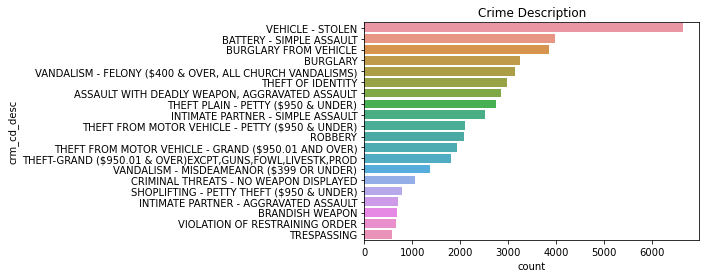

In [132]:
sns.countplot(y = 'crm_cd_desc', order=df.crm_cd_desc.value_counts().iloc[:20].index, data=df).set_title('Crime Description')

The figure above shoes that vehicle crime ranks highly amoung the different types of crime in LA. Specifically, instances of stolen vehicles occurs far greater than any other type of crime. 

Text(0.5, 1.0, 'Crime Scene')

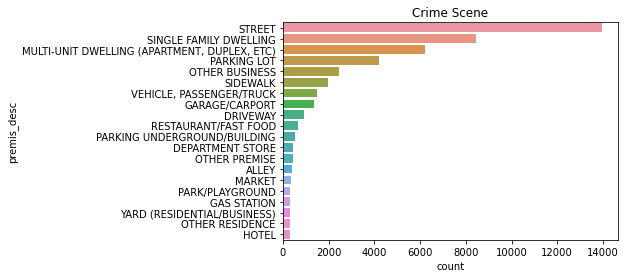

In [131]:
sns.countplot(y = 'premis_desc', order=df.premis_desc.value_counts().iloc[:20].index, data=df).set_title('Crime Scene')

It is clear in the graph above that street crimes occurs the most.

Text(0.5, 1.0, 'Victim Race')

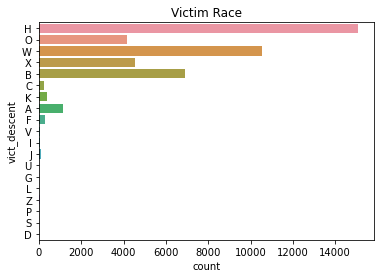

In [34]:
sns.countplot(y = 'vict_descent', data=df).set_title('Victim Race')

The H in the figure corresponds to hispanics, and W as White. The figure shows that out of the crime reports the hispanics had the highest count as the victim's race

<AxesSubplot:xlabel='count', ylabel='area_name'>

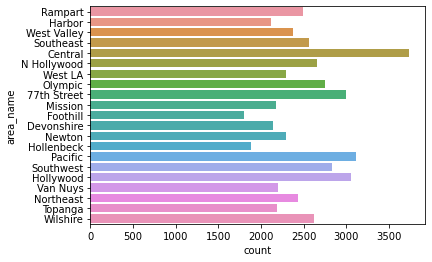

In [116]:
sns.countplot(y = 'area_name', data=df)

The distribution of crime per neighborhood is fairly even, with central LA noticablly having slightly more crime than the other neighborhoods. 